In [2]:
%load_ext autoreload
%autoreload 2

from pathlib import Path
from hmpai.pytorch.training import train, validate, calculate_class_weights, train_and_test, k_fold_cross_validate, test
from hmpai.pytorch.utilities import DEVICE, set_global_seed, get_summary_str, save_model, load_model
from hmpai.pytorch.generators import SAT1Dataset

from hmpai.data import SAT1_STAGES_ACCURACY, SAT_CLASSES_ACCURACY
from hmpai.visualization import plot_confusion_matrix
from hmpai.normalization import *
from torch.utils.data import DataLoader

from torchvision.transforms import Compose
from hmpai.pytorch.transforms import *
from hmpai.behaviour.sat2 import read_behavioural_info
import matplotlib.pyplot as plt

import seaborn as sns

In [1]:
import netCDF4
import xarray as xr
import os
from pathlib import Path
from hmpai.pytorch.models import *
from hmpai.training import split_data_on_participants
import pandas as pd

DATA_PATH = Path(os.getenv("DATA_PATH"))
data_path = DATA_PATH / "sat2/split_stage_data_100hz.nc"
dataset = xr.load_dataset(data_path)

In [3]:
dataset

<xarray.Dataset> Size: 5GB
Dimensions:      (channels: 30, samples: 100, epochs: 2446, participant: 18,
                  labels: 5)
Coordinates:
  * channels     (channels) <U3 360B 'Fp1' 'Fp2' 'AFz' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) int64 800B 0 1 2 3 4 5 6 7 ... 93 94 95 96 97 98 99
  * epochs       (epochs) int64 20kB 0 1 2 3 4 5 ... 2442 2443 2444 2445 2446
  * participant  (participant) <U3 216B 'S1' 'S10' 'S11' ... 'S7' 'S8' 'S9'
  * labels       (labels) <U13 260B 'confirmation' 'decision' ... 'response'
    event_name   (participant, epochs) <U21 4MB '' 'low/speed/right/1' ... ''
    rt           (participant, epochs) float64 352kB nan 0.4092 ... 1.319 nan
Data variables:
    data         (participant, epochs, labels, channels, samples) float64 5GB ...

In [4]:
# Accuracy (training)
indexer = (dataset.cue == 'AC' if 'sat1' in str(data_path) else dataset.event_name.str.contains("accuracy"))
dataset_acc = dataset.where(indexer, drop=True)
# del dataset

In [5]:
# Speed (inference)
indexer = (dataset.cue == 'SP' if 'sat1' in str(data_path) else dataset.event_name.str.contains("speed"))
dataset_sp = dataset.where(indexer, drop=True)
del dataset

In [6]:
shape_topological = False
info_to_keep = ['rt', 'participant', 'epochs']
set_global_seed(42)
train_data, val_data, test_data = split_data_on_participants(
    dataset_acc, 60, norm_min1_to_1
)
transform = Compose([ChannelsDropout(probability=0.5, p_drop=0.4)])
# transform = Compose([GaussianNoise(0.5, 0.16)])
# transform = Compose([ChannelsDropout(0.5, 0.4), TimeReverse(0.5)])
# transform = Compose([ChannelsDropout(0.33, 0.4), TimeReverse(0.33), GaussianNoise(0.33, 0.16)])
# del dataset_acc
train_dataset = SAT1Dataset(train_data, shape_topological=shape_topological, labels=SAT_CLASSES_ACCURACY, transform=transform)
# train_dataset = SAT1Dataset(train_data, shape_topological=shape_topological, labels=SAT_CLASSES_ACCURACY)
# del train_data
val_dataset = SAT1Dataset(val_data, shape_topological=shape_topological, labels=SAT_CLASSES_ACCURACY)
# del val_data
test_dataset = SAT1Dataset(test_data, shape_topological=shape_topological, labels=SAT_CLASSES_ACCURACY, info_to_keep=info_to_keep)
# del test_data

['S12', 'S1', 'S18', 'S9', 'S6', 'S11', 'S3', 'S10']


In [7]:
set_global_seed(42)
_, _, test_data_sp = split_data_on_participants(
    dataset_sp, 60, norm_min1_to_1
)
test_dataset_sp = SAT1Dataset(test_data_sp, shape_topological=shape_topological, labels=SAT_CLASSES_ACCURACY, info_to_keep=info_to_keep)


['S12', 'S1', 'S18', 'S9', 'S6', 'S11', 'S3', 'S10']


### Training

In [14]:
model = MambaModel(embed_dim=256, n_channels=30, n_classes=5, n_layers=4, global_pool=True, dropout=0.1)
# model = SAT1GRU(n_channels=30, n_samples=100, n_classes=5)
train_and_test(
    model,
    # train_dataset,
    test_dataset_sp, # Validate using speed to see metric progression over training
    [test_dataset, test_dataset_sp],
    val_dataset, # val_dataset
    logs_path=Path("../logs/"),
    epochs=20,
    workers=0,
    batch_size=128,
    labels=SAT_CLASSES_ACCURACY,
    weight_decay=0.001,
    label_smoothing=0.01,
    # lr=0.00001,
    do_spectral_decoupling=False,
)

  0%|          | 0/134 [00:00<?, ? batch/s]

              precision    recall  f1-score   support

           0       0.19      1.00      0.32      3912
           1       0.00      0.00      0.00      4249
           2       0.36      0.03      0.06      4249
           3       0.00      0.00      0.00      4249
           4       0.00      0.00      0.00      4249

    accuracy                           0.19     20908
   macro avg       0.11      0.21      0.08     20908
weighted avg       0.11      0.19      0.07     20908



/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


  0%|          | 0/134 [00:00<?, ? batch/s]

              precision    recall  f1-score   support

           0       0.45      0.98      0.62      3912
           1       0.12      0.17      0.14      4249
           2       0.46      0.14      0.21      4249
           3       0.00      0.00      0.00      4249
           4       0.02      0.02      0.02      4249

    accuracy                           0.25     20908
   macro avg       0.21      0.26      0.20     20908
weighted avg       0.21      0.25      0.19     20908



/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


  0%|          | 0/134 [00:00<?, ? batch/s]

              precision    recall  f1-score   support

           0       0.46      0.92      0.61      3912
           1       0.34      0.67      0.45      4249
           2       0.49      0.32      0.38      4249
           3       0.00      0.00      0.00      4249
           4       0.27      0.12      0.17      4249

    accuracy                           0.40     20908
   macro avg       0.31      0.41      0.32     20908
weighted avg       0.31      0.40      0.32     20908



/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


  0%|          | 0/134 [00:00<?, ? batch/s]

              precision    recall  f1-score   support

           0       0.65      0.85      0.74      3912
           1       0.54      0.79      0.64      4249
           2       0.50      0.67      0.57      4249
           3       0.00      0.00      0.00      4249
           4       0.66      0.59      0.62      4249

    accuracy                           0.58     20908
   macro avg       0.47      0.58      0.51     20908
weighted avg       0.47      0.58      0.51     20908



/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


  0%|          | 0/134 [00:00<?, ? batch/s]

              precision    recall  f1-score   support

           0       0.72      0.84      0.77      3912
           1       0.50      0.80      0.61      4249
           2       0.51      0.60      0.55      4249
           3       0.00      0.00      0.00      4249
           4       0.69      0.72      0.70      4249

    accuracy                           0.59     20908
   macro avg       0.48      0.59      0.53     20908
weighted avg       0.48      0.59      0.52     20908



/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


  0%|          | 0/134 [00:00<?, ? batch/s]

              precision    recall  f1-score   support

           0       0.53      0.88      0.66      3912
           1       0.28      0.48      0.35      4249
           2       0.50      0.32      0.39      4249
           3       0.00      0.00      0.00      4249
           4       0.30      0.32      0.31      4249

    accuracy                           0.39     20908
   macro avg       0.32      0.40      0.34     20908
weighted avg       0.32      0.39      0.34     20908



/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


  0%|          | 0/134 [00:00<?, ? batch/s]

/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


              precision    recall  f1-score   support

           0       0.38      0.99      0.55      3912
           1       0.06      0.01      0.02      4249
           2       0.46      0.14      0.22      4249
           3       0.00      0.00      0.00      4249
           4       0.00      0.00      0.00      4249

    accuracy                           0.22     20908
   macro avg       0.18      0.23      0.16     20908
weighted avg       0.18      0.22      0.15     20908



/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[{'0.0': {'precision': 0.6952998379254457,
   'recall': 0.9159327461969575,
   'f1-score': 0.7905101923298399,
   'support': 3747.0},
  '1.0': {'precision': 0.4454211283362634,
   'recall': 0.6854402361042794,
   'f1-score': 0.5399593141528626,
   'support': 4066.0},
  '2.0': {'precision': 0.553899330308922,
   'recall': 0.6305951795376291,
   'f1-score': 0.5897642323174238,
   'support': 4066.0},
  '3.0': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 4066.0},
  '4.0': {'precision': 0.6275960849844832,
   'recall': 0.646581406787998,
   'f1-score': 0.6369473046638401,
   'support': 4066.0},
  'accuracy': 0.5702863425116186,
  'macro avg': {'precision': 0.46444327631102283,
   'recall': 0.5757099137253728,
   'f1-score': 0.5114362086927933,
   'support': 20011.0},
  'weighted avg': {'precision': 0.4607631382292178,
   'recall': 0.5702863425116186,
   'f1-score': 0.5069874254845469,
   'support': 20011.0}},
 {'0.0': {'precision': 0.9255503339104625,
   'recall': 0.9329344

### Examining

In [12]:
test_loader = DataLoader(
    test_dataset, 128, shuffle=True, num_workers=0, pin_memory=True
)
results, pred, true = test(model, test_loader, None, class_labels=SAT_CLASSES_ACCURACY)
pred = pred.cpu()

/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


0.6741292289240918


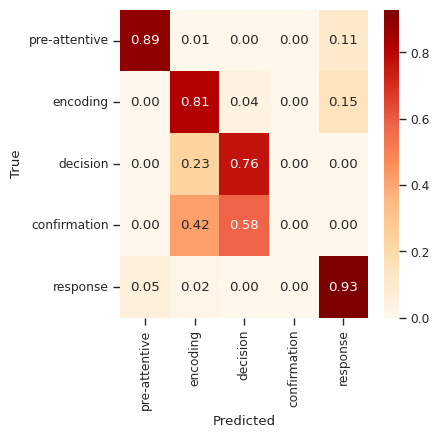

In [13]:
plot_confusion_matrix(true, pred, SAT_CLASSES_ACCURACY)

In [7]:
# Load model
chk_path = Path("../models/sat2_mamba_gen.pt")
checkpoint = load_model(chk_path)

model_kwargs = {
    "embed_dim": 256,
    "n_channels": 30,
    "n_classes": 5,
    "n_layers": 6,
    "global_pool": True,
}
model = MambaModel(**model_kwargs)
model.load_state_dict(checkpoint["model_state_dict"])
model = model.to(DEVICE)

In [18]:
# In speed test set, get all true decision labels and predict them
torch.cuda.empty_cache()
torch.set_grad_enabled(False)
softmax = torch.nn.Softmax(dim=1)
pred_probas = []
rts = []
participants = []
epochs = []
cnt = 0
for item in test_dataset_sp:
    # 'rt' must be in info_to_keep
    data, label, info = item
    rt = info['rt']
    part = info['participant']
    epoch = info['epochs']
    # Decision
    if label == 2:
        pred = model(data.unsqueeze(0).to(DEVICE))
        probas = softmax(pred)
        pred_probas.append(probas.squeeze())
        rts.append(rt)
        participants.append(part)
        epochs.append(epoch)
    cnt += 1
    if cnt > np.inf:
        break
probas = torch.stack(pred_probas)

In [19]:
data = pd.DataFrame(probas.detach().cpu(), columns=SAT_CLASSES_ACCURACY)
data['rt'] = rts
data['participant'] = participants
data['epoch'] = epochs
data = data.merge(behaviour_sat2, left_on=["participant", "epoch"], right_on=["participant", "trial"])

In [20]:
q1 = data.decision.quantile(0.33)
q2 = data.decision.quantile(0.66)
print(q1, q2)
data['q'] = pd.cut(data['decision'], bins=[-np.inf, q1, q2, np.inf], labels=['first', 'second', 'third'])

0.7896398150920868 0.8889751255512237


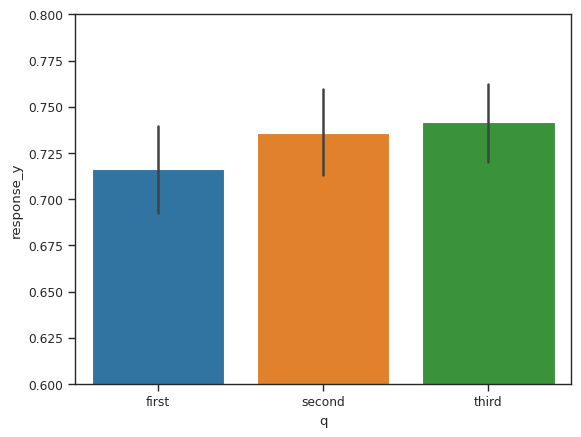

In [21]:
# Lower probability of decision should imply greater probability of it including confirmation activity
# But it doesnt? Lower probability of decision being classified as decision implies slightly worse performance
# Model could have just learned what decision operation starts with (given that we think most identifying information occurs around the transition event)
# And just predicts decision confidently
sns.barplot(data, x='q', y='response_y', hue='q')
plt.ylim(0.6,0.8)
plt.show()

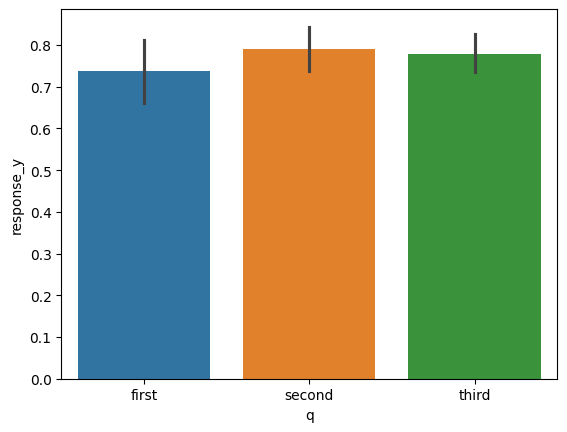

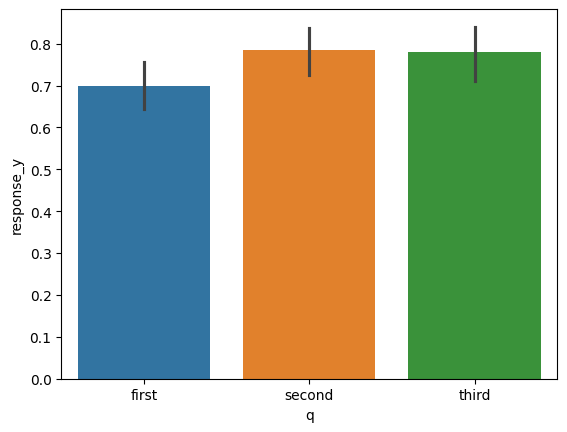

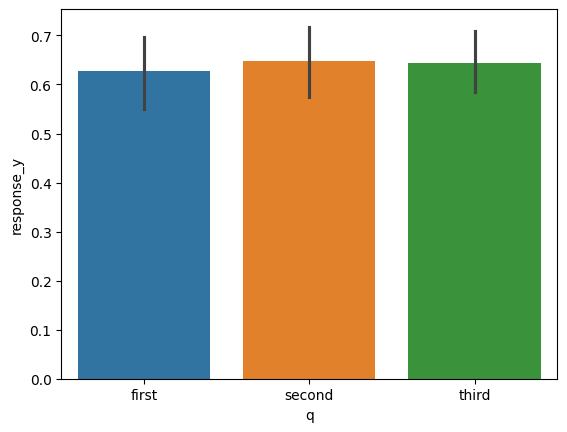

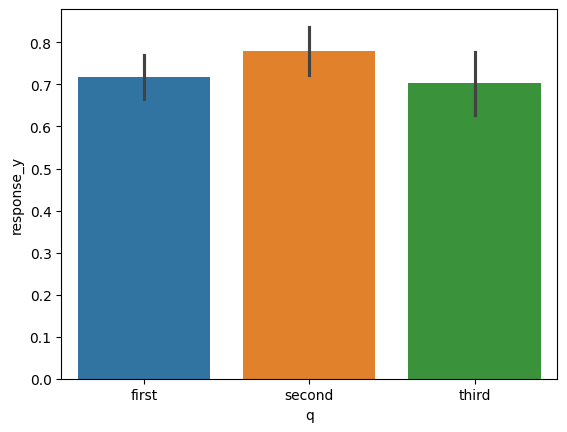

In [86]:
for participant in test_data.participant:
    sns.barplot(data[data.participant == participant], x='q', y='response_y', hue='q')
    plt.show()

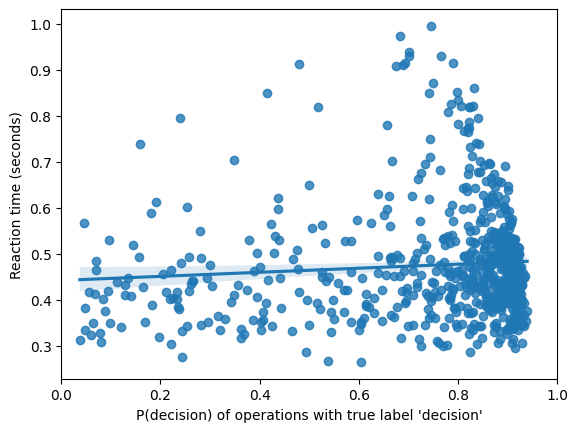

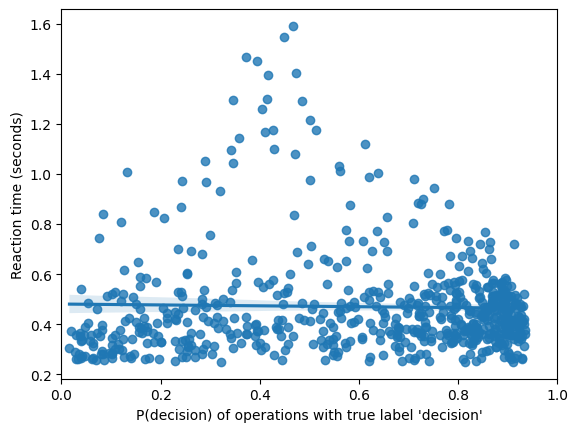

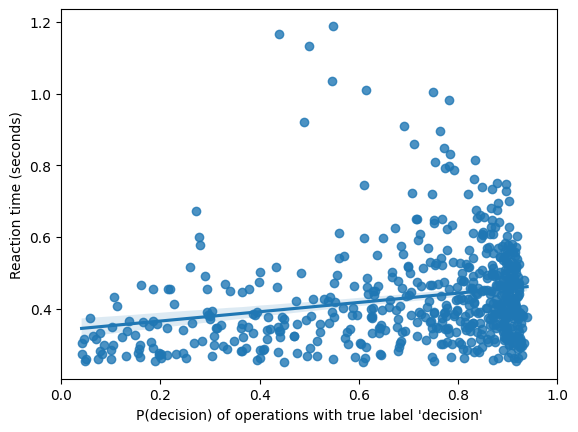

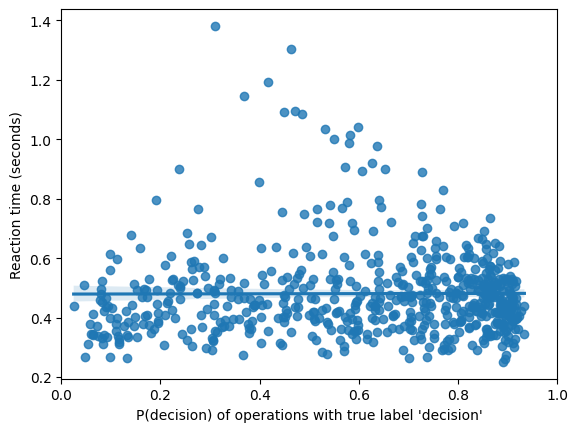

In [68]:
for participant in test_data.participant:
    sns.regplot(data[data.participant == participant], x='decision', y='rt_x')
    plt.xlim(0,1)
    plt.xlabel("P(decision) of operations with true label 'decision'")
    plt.ylabel("Reaction time (seconds)")
    plt.show()

<Axes: xlabel='decision', ylabel='rt_x'>

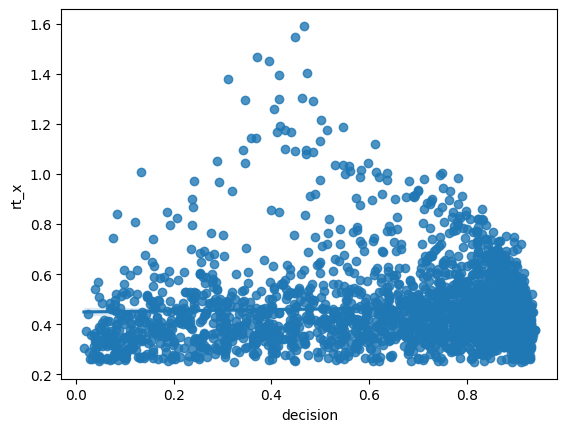

In [59]:
# Maybe pattern per participant?
# Maybe we dont expect
for participant in test
sns.regplot(data, x='decision', y='rt_x')

In [10]:
probas.mean(dim=0)
# Check if probability of confirmation (or being uncertain about decision) correlates with RT?
# Maybe check parts of longer stages to check if confirmation is predicted

tensor([0.0300, 0.1742, 0.6647, 0.0966, 0.0345], device='cuda:0',
       grad_fn=<MeanBackward1>)